# Training Comparisons and Evaluations

##### Authors:
1. Ovidio Manteiga Moar
1. Carlos Villar Martínez

In this notebook the goal is to train a VAE. The process is similar than for the other VAE the only thing that changes are some hyperparameters.

In [1]:
from Data_pre import prepare_data_generator_VAE
import numpy as np
import glob, os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, callbacks, utils, metrics, optimizers
from keras.callbacks import ModelCheckpoint 
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
import PIL

## VAE

In [2]:
DATA_FOLDER = "./Dataset/img_align_celeba"

Here we use different parameters. With the bigger input size we should obtain better results.

In [3]:
INPUT_DIM = (128, 128, 1)
BATCH_SIZE = 512
Z_DIM = 200

data_flow, NUM_IMAGES = prepare_data_generator_VAE(DATA_FOLDER, INPUT_DIM, BATCH_SIZE)

Total number of images: 202599
Found 202599 images belonging to 1 classes.


First of all lets define the encoder.

In [4]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, conv_strides):
  
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()
    
    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    encoder_input = Input(shape = input_dim, name = 'encoder_input')
    x = encoder_input

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2D(filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'encoder_conv_' + str(i)
            )(x)

        x = LeakyReLU()(x)
        
    # Required for reshaping latent vector while building Decoder
    shape_before_flattening = K.int_shape(x)[1:] 
    
    x = Flatten()(x)
    mean_mu = Dense(output_dim, name = 'mu')(x)
    log_var = Dense(output_dim, name = 'log_var')(x)

    # Defining a function for sampling
    def sampling(args):
        mean_mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon   

    # Using a Keras Lambda Layer to include the sampling function as a layer 
    # in the model
    encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])


    return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)


vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(
    input_dim = INPUT_DIM,
    output_dim = Z_DIM, 
    #conv_filters = [32, 64, 64, 64],
    conv_filters = [16, 32, 32, 32],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2])

vae_encoder.summary()

plot_model(vae_encoder, show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']        

Lets go now with the decoder

In [5]:
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, conv_strides):

    # Number of Conv layers
    n_layers = len(conv_filters)

    # Define model input
    decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

    # To get an exact mirror image of the encoder
    x = Dense(np.prod(shape_before_flattening))(decoder_input)
    x = Reshape(shape_before_flattening)(x)

    # Add convolutional layers
    for i in range(n_layers):
        x = Conv2DTranspose(
            filters = conv_filters[i], 
            kernel_size = conv_kernel_size[i],
            strides = conv_strides[i], 
            padding = 'same',
            name = 'decoder_conv_' + str(i)
            )(x)
        
        # Adding a sigmoid layer at the end to restrict the outputs 
        # between 0 and 1
        if i < n_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)

    # Define model output
    decoder_output = x

    return decoder_input, decoder_output, Model(decoder_input, decoder_output)

decoder_input, decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
    shape_before_flattening = vae_shape_before_flattening,
    #conv_filters = [64,64,32,3],        
    conv_filters = [32,32,16,1],
    conv_kernel_size = [3,3,3,3],
    conv_strides = [2,2,2,2]
    )

vae_decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 2048)              411648    
                                                                 
 reshape (Reshape)           (None, 8, 8, 32)          0         
                                                                 
 decoder_conv_0 (Conv2DTrans  (None, 16, 16, 32)       9248      
 pose)                                                           
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 32)        0         
                                                                 
 decoder_conv_1 (Conv2DTrans  (None, 32, 32, 32)       9248      
 pose)                                                     

Now we have to attach the encoder and the decoder.

In [6]:
vae_input = vae_encoder_input
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae = Model(vae_input, vae_output)

vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 encoder_conv_0 (Conv2D)        (None, 64, 64, 16)   160         ['encoder_input[0][0]']          
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 16)   0           ['encoder_conv_0[0][0]']         
                                                                                                  
 encoder_conv_1 (Conv2D)        (None, 32, 32, 32)   4640        ['leaky_re_lu[0][0]']      

Compile and train

In [7]:
def plot_compare_VAE(images, add_noise=False):
    
    n_to_show = images.shape[0]

    if add_noise:
        encodings = VAE_encoder.predict(images)
        encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
        reconst_images = VAE_decoder.predict(encodings)

    else:
        reconst_images = vae.predict(images)


    fig = plt.figure(figsize=(12, 3))
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, hspace=0.1, wspace=0.1)

    for i in range(n_to_show):
        #img = images[i].squeeze()
        img = images[i]
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img,cmap='gray')

    for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
        sub.axis('off')
        sub.imshow(img,cmap='gray')
    plt.show()

We use also more number of epochs than for the other VAE, this should also help to get better results.

Epoch 1/2
395/395 [==============================] - 543s 1s/step - batch: 197.5000 - size: 511.6136 - loss: 379.6223 - r_loss: 0.0335 - kl_loss: 44.9030
Epoch 2/2
395/395 [==============================] - 347s 878ms/step - batch: 197.5000 - size: 511.6136 - loss: 231.6845 - r_loss: 0.0178 - kl_loss: 54.0066


c:\Users\corre\anaconda3\envs\gan\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


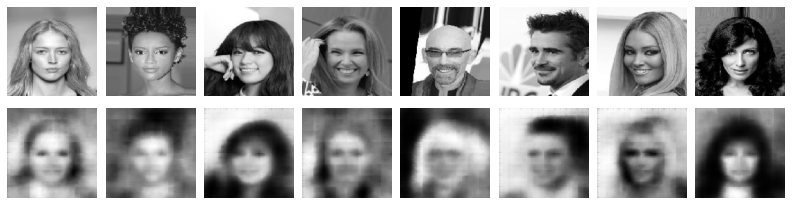

Epoch 1/2
395/395 [==============================] - 323s 817ms/step - batch: 197.5000 - size: 511.6136 - loss: 208.9503 - r_loss: 0.0156 - kl_loss: 53.2566
Epoch 2/2
395/395 [==============================] - 326s 825ms/step - batch: 197.5000 - size: 511.6136 - loss: 201.7211 - r_loss: 0.0147 - kl_loss: 54.3180


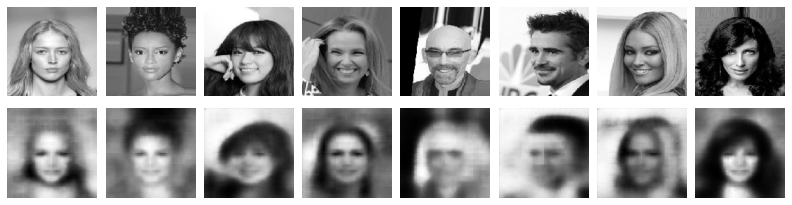

Epoch 1/2
395/395 [==============================] - 419s 1s/step - batch: 197.5000 - size: 511.6136 - loss: 197.7584 - r_loss: 0.0143 - kl_loss: 54.9989
Epoch 2/2
395/395 [==============================] - 645s 2s/step - batch: 197.5000 - size: 511.6136 - loss: 194.9663 - r_loss: 0.0140 - kl_loss: 55.4063


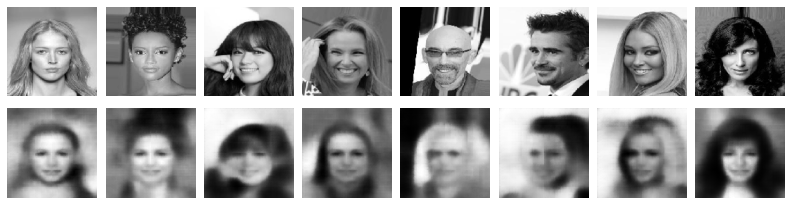

Epoch 1/2
395/395 [==============================] - 343s 866ms/step - batch: 197.5000 - size: 511.6136 - loss: 192.7979 - r_loss: 0.0137 - kl_loss: 55.7257
Epoch 2/2
395/395 [==============================] - 321s 812ms/step - batch: 197.5000 - size: 511.6136 - loss: 191.0534 - r_loss: 0.0135 - kl_loss: 55.9274


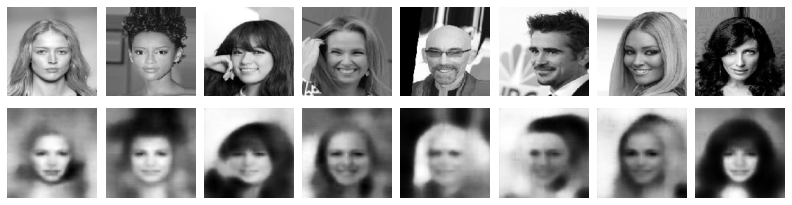

Epoch 1/2
395/395 [==============================] - 321s 812ms/step - batch: 197.5000 - size: 511.6136 - loss: 189.6843 - r_loss: 0.0134 - kl_loss: 56.0346
Epoch 2/2
395/395 [==============================] - 323s 816ms/step - batch: 197.5000 - size: 511.6136 - loss: 188.5070 - r_loss: 0.0132 - kl_loss: 56.1194


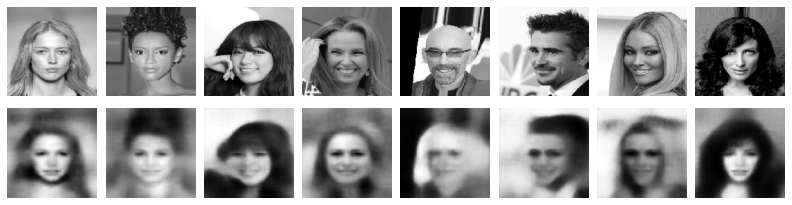

Epoch 1/2
395/395 [==============================] - 323s 815ms/step - batch: 197.5000 - size: 511.6136 - loss: 187.4560 - r_loss: 0.0131 - kl_loss: 56.1704
Epoch 2/2
395/395 [==============================] - 321s 811ms/step - batch: 197.5000 - size: 511.6136 - loss: 186.5757 - r_loss: 0.0130 - kl_loss: 56.2004


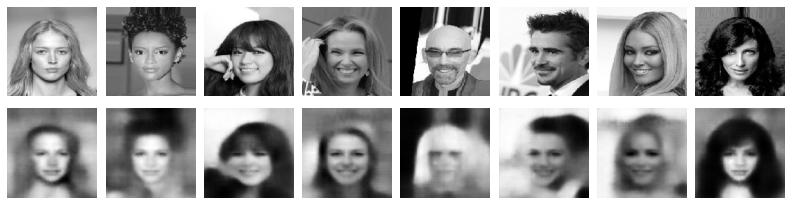

Epoch 1/2
395/395 [==============================] - 324s 818ms/step - batch: 197.5000 - size: 511.6136 - loss: 185.7330 - r_loss: 0.0130 - kl_loss: 56.2224
Epoch 2/2
395/395 [==============================] - 325s 821ms/step - batch: 197.5000 - size: 511.6136 - loss: 184.9835 - r_loss: 0.0129 - kl_loss: 56.2200


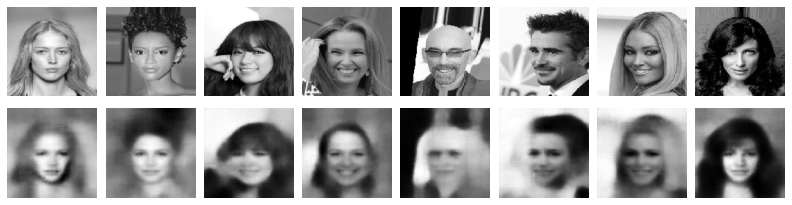

Epoch 1/2
395/395 [==============================] - 605s 2s/step - batch: 197.5000 - size: 511.6136 - loss: 184.3271 - r_loss: 0.0128 - kl_loss: 56.2110
Epoch 2/2
395/395 [==============================] - 497s 1s/step - batch: 197.5000 - size: 511.6136 - loss: 183.7237 - r_loss: 0.0128 - kl_loss: 56.2187


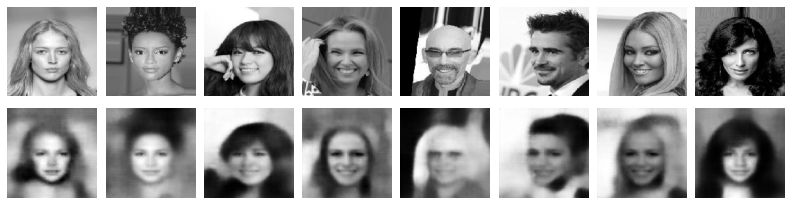

Epoch 1/2
395/395 [==============================] - 395s 998ms/step - batch: 197.5000 - size: 511.6136 - loss: 183.2467 - r_loss: 0.0127 - kl_loss: 56.2333
Epoch 2/2
395/395 [==============================] - 397s 1s/step - batch: 197.5000 - size: 511.6136 - loss: 182.6920 - r_loss: 0.0126 - kl_loss: 56.2185


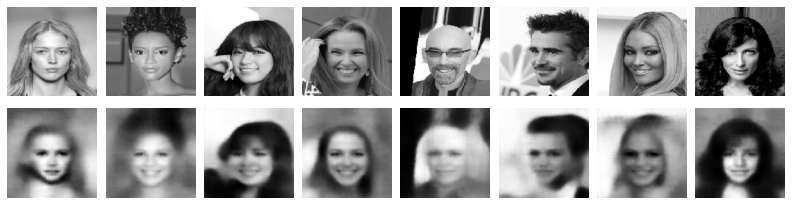

Epoch 1/2
395/395 [==============================] - 398s 1s/step - batch: 197.5000 - size: 511.6136 - loss: 182.2449 - r_loss: 0.0126 - kl_loss: 56.2356
Epoch 2/2
395/395 [==============================] - 386s 975ms/step - batch: 197.5000 - size: 511.6136 - loss: 181.8440 - r_loss: 0.0126 - kl_loss: 56.2560


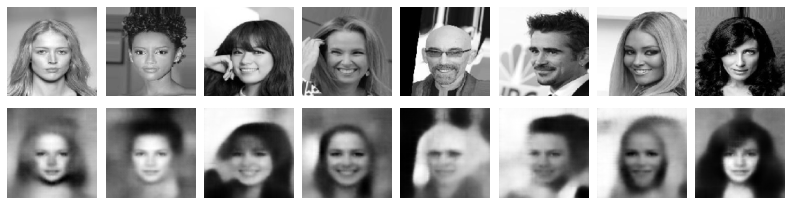

In [8]:
LEARNING_RATE = 0.0005
N_EPOCHS = 2  # No. of epochs to show advance
N_BLOCKS = 10
LOSS_FACTOR = 10000

adam_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)



vae.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])


example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:8]

for i in range(N_BLOCKS):
    vae.fit(data_flow, 
        shuffle=True, 
        epochs = N_EPOCHS, 
        initial_epoch = 0, 
        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)
    plot_compare_VAE(example_images) 

We can clearly see that the results are better than with the other VAE, even some of the faces seem that are real human faces but in a blurred picture. Again, with a more powerful unit we could probably get pretty decent results.